In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Clean_Dataset2.csv')

Mounted at /content/drive


In [3]:
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["class"]
)

In [4]:
# ==========================================
# STEP 0: INITIAL CLEANUP
# ==========================================
print("\n--- Step 0: Dropping Useless ID Columns ---")

# List of columns to drop immediately
# 'flight': Just an ID, acts like a name, contains no pattern info
cols_to_drop = ['flight']

# Drop from Training Data
# (Assuming your dataframe is named 'train_df' or 'df')
if 'flight' in train_df.columns:
    train_df = train_df.drop(columns=cols_to_drop, errors='ignore')
    print("Dropped 'flight' from Training Data.")

# Drop from Test Data
if 'flight' in test_df.columns:
    test_df = test_df.drop(columns=cols_to_drop, errors='ignore')
    print("Dropped 'flight' from Test Data.")

# Verify
print(f"Train Shape: {train_df.shape}")
print(f"Test Shape:  {test_df.shape}")


--- Step 0: Dropping Useless ID Columns ---
Dropped 'flight' from Training Data.
Dropped 'flight' from Test Data.
Train Shape: (80000, 10)
Test Shape:  (20000, 10)


In [5]:
import numpy as np
import pandas as pd

print("\n--- Step 1: Transformations & Encoding ---")

def preprocess_data(data):
    data = data.copy()

    # 1. Log Transformations (Creating the ingredients for Linear Models)
    # We use log1p to handle zeros safely
    # Note: We create 'price_log' here, but we will separate it later.
    if 'price' in data.columns:
        data['price_log'] = np.log1p(data['price'])

    data['duration_log'] = np.log1p(data['duration'])
    data['days_left_log'] = np.log1p(data['days_left'])

    # 2. Ordinal Encoding for 'stops' (Manual mapping)
    stops_mapping = {'zero': 0, 'one': 1, 'two_or_more': 2}
    if 'stops' in data.columns:
        data['stops_num'] = data['stops'].map(stops_mapping)
        # Drop the original text column
        data = data.drop(columns=['stops'], errors='ignore')

    # 3. One-Hot Encoding (For Airlines, Cities, etc.)
    # identifying categorical columns that need dummy encoding
    # (Assuming 'class', 'airline', 'source_city', etc. are strictly categorical)
    cat_cols = data.select_dtypes(include=['object']).columns.tolist()

    # Create dummy variables (0/1)
    data = pd.get_dummies(data, columns=cat_cols, drop_first=True) # drop_first=True avoids dummy trap

    return data

# Apply transformations to the training and test sets
# (Assuming 'train_df' and 'test_df' are your raw loaded dataframes)
df_train_final = preprocess_data(train_df)
df_test_final = preprocess_data(test_df)

# Add a 'set_type' column for tracking (Optional, but good for safety)
df_train_final['set_type'] = 'train'
df_test_final['set_type'] = 'test'

print("\nFinal Train Shape:", df_train_final.shape)
print("Final Test Shape:", df_test_final.shape)

# Quick check to ensure we have all versions
print("\nCheck for required columns:")
print(f"Has 'price'? {'price' in df_train_final.columns}")
print(f"Has 'price_log'? {'price_log' in df_train_final.columns}")
print(f"Has 'duration'? {'duration' in df_train_final.columns}")
print(f"Has 'duration_log'? {'duration_log' in df_train_final.columns}")


--- Step 1: Transformations & Encoding ---

Final Train Shape: (80000, 34)
Final Test Shape: (20000, 34)

Check for required columns:
Has 'price'? True
Has 'price_log'? True
Has 'duration'? True
Has 'duration_log'? True


In [6]:
# ==========================================
# 2. ENCODING CATEGORICAL VARIABLES
# ==========================================
print("\n--- Step 2: Encoding Categorical Variables ---")
from sklearn.preprocessing import LabelEncoder

def encode_data(train, test):
    # We combine them temporarily to ensure all categories are captured
    train['dataset'] = 'train'
    test['dataset'] = 'test'

    combined = pd.concat([train, test], axis=0)

    # 1. Label Encode Binary/Ordinal Columns
    # 'class': Economy=0, Business=1
    le = LabelEncoder()
    if 'class' in combined.columns:
        combined['class'] = le.fit_transform(combined['class'])
        print("Class Encoding Mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

    # 2. One-Hot Encode Nominal Columns
    # Note: We EXCLUDE 'stops_num' because it is already numeric (0,1,2)
    nominal_cols = ['airline', 'source_city', 'destination_city', 'departure_time', 'arrival_time']

    # Only encode columns that actually exist in the dataframe
    existing_cols = [c for c in nominal_cols if c in combined.columns]

    combined = pd.get_dummies(combined, columns=existing_cols, drop_first=True)

    # Split back into Train, Test
    train_enc = combined[combined['dataset'] == 'train'].drop(columns=['dataset'])
    test_enc = combined[combined['dataset'] == 'test'].drop(columns=['dataset'])

    return train_enc, test_enc

# Apply Encoding
# (Assumes df_train_final/df_test_final come from Step 1)
df_train_enc, df_test_enc = encode_data(df_train_final, df_test_final)

# Final Check
print("\nEncoding Complete.")
print(f"Train Shape: {df_train_enc.shape}")
print(f"Test Shape: {df_test_enc.shape}")

# Preview columns to verify we have everything
print("\nColumns available:", df_train_enc.columns.tolist())


--- Step 2: Encoding Categorical Variables ---

Encoding Complete.
Train Shape: (80000, 34)
Test Shape: (20000, 34)

Columns available: ['duration', 'days_left', 'price', 'price_log', 'duration_log', 'days_left_log', 'stops_num', 'airline_Air_India', 'airline_GO_FIRST', 'airline_Indigo', 'airline_SpiceJet', 'airline_Vistara', 'source_city_Chennai', 'source_city_Delhi', 'source_city_Hyderabad', 'source_city_Kolkata', 'source_city_Mumbai', 'departure_time_Early_Morning', 'departure_time_Evening', 'departure_time_Late_Night', 'departure_time_Morning', 'departure_time_Night', 'arrival_time_Early_Morning', 'arrival_time_Evening', 'arrival_time_Late_Night', 'arrival_time_Morning', 'arrival_time_Night', 'destination_city_Chennai', 'destination_city_Delhi', 'destination_city_Hyderabad', 'destination_city_Kolkata', 'destination_city_Mumbai', 'class_Economy', 'set_type']


In [7]:
# ==========================================
# 3. SPLITTING & HANDLING FEATURE SETS
# ==========================================
print("\n--- Step 3: Splitting & Leakage Removal ---")
from sklearn.model_selection import train_test_split

# A. Separate Target (y) from Features (X)
# -------------------------------------------------------
# Target is ALWAYS Log Price (for all models)
y = df_train_enc['price_log']

# Initial X (Contains everything including leakage columns for now)
X = df_train_enc.drop(columns=['price_log', 'price', 'set_type'], errors='ignore')

# B. Train-Test Split (80% Train, 20% Eval) - NOW STRATIFIED
# -------------------------------------------------------
# We stratify on 'class' to keep the Economy/Business balance perfect.
X_train_full, X_eval_full, y_train, y_eval = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=df_train_enc['class_Economy']  # <--- THIS IS THE FIX
)

# C. Create Specific Feature Sets (The Fix)
# -------------------------------------------------------

# 1. Define Leakage (Just to be triple sure)
# We already dropped 'price' and 'price_log' above, but this variable
# helps us clean up other redundant columns.
leakage_cols = ['price', 'price_log']

# 2. Set A: For LINEAR Models (MLR, KNN, SVR)
# Needs: Log Transforms (duration_log)
# Hates: Original Skewed Data (duration) + Multicollinearity
drop_for_linear = ['duration', 'days_left']

X_train_linear = X_train_full.drop(columns=drop_for_linear, errors='ignore')
X_eval_linear = X_eval_full.drop(columns=drop_for_linear, errors='ignore')

# 3. Set B: For TREE Models (XGBoost, RF)
# Needs: Original Data (duration) - Easier to interpret
# Hates: Log Transforms (duration_log) - Adds noise
drop_for_trees = ['duration_log', 'days_left_log']

X_train_tree = X_train_full.drop(columns=drop_for_trees, errors='ignore')
X_eval_tree = X_eval_full.drop(columns=drop_for_trees, errors='ignore')

# --- Verification ---
print(f"Original Shape:   {X_train_full.shape}")
print(f"Linear Set Shape: {X_train_linear.shape} (Used for MLR, ANN, SVR)")
print(f"Tree Set Shape:   {X_train_tree.shape}   (Used for XGB, RF)")

print("\nSafety Check (Should be FALSE):")
print(f"Does Linear Set have 'price'?     {'price' in X_train_linear.columns}")
print(f"Does Tree Set have 'price_log'?   {'price_log' in X_train_tree.columns}")


--- Step 3: Splitting & Leakage Removal ---
Original Shape:   (64000, 31)
Linear Set Shape: (64000, 29) (Used for MLR, ANN, SVR)
Tree Set Shape:   (64000, 29)   (Used for XGB, RF)

Safety Check (Should be FALSE):
Does Linear Set have 'price'?     False
Does Tree Set have 'price_log'?   False


In [8]:
# ==========================================
# 4. SCALING (StandardScaler)
# ==========================================
print("\n--- Step 4: Scaling for Linear Models ---")
from sklearn.preprocessing import StandardScaler
import numpy as np # Ensure numpy is imported for operations like .mean() if not already

# We only scale the 'Linear' set.
# (Tree models in Step 13 don't need scaling).
scaler = StandardScaler()

# --- NEW: Identify and drop columns that are entirely NaN ---
all_nan_cols = X_train_linear.columns[X_train_linear.isnull().all()]
if not all_nan_cols.empty:
    print(f"Dropping {len(all_nan_cols)} columns that are entirely NaN: {list(all_nan_cols)}")
    X_train_linear = X_train_linear.drop(columns=all_nan_cols, axis=1)
    X_eval_linear = X_eval_linear.drop(columns=all_nan_cols, axis=1)

# Identify columns with zero standard deviation (which cause NaNs during scaling)
# This is crucial for one-hot encoded columns that might be all 0s or all 1s in a subset
# Filter for numeric columns before calculating std() to avoid errors on non-numeric types if any exist
numeric_cols_train = X_train_linear.select_dtypes(include=np.number).columns # Re-select after dropping all_nan_cols
zero_std_cols = numeric_cols_train[X_train_linear[numeric_cols_train].std() == 0]

# Drop these columns from both training and evaluation sets for linear models
if not zero_std_cols.empty:
    print(f"Dropping {len(zero_std_cols)} columns with zero standard deviation: {list(zero_std_cols)}")
    X_train_linear = X_train_linear.drop(columns=zero_std_cols, axis=1)
    X_eval_linear = X_eval_linear.drop(columns=zero_std_cols, axis=1)

# --- Handle any remaining NaN values before scaling ---
# Impute NaNs with the mean of the training set for each column
# This needs to be done *after* dropping all-NaN and zero_std_cols and *before* scaling.
# We iterate over columns to ensure mean calculation is robust
print("Checking for and imputing NaN values...")
for col in X_train_linear.columns:
    if X_train_linear[col].isnull().any():
        print(f"  - Imputing NaNs in column '{col}' with its training mean.")
        mean_val = X_train_linear[col].mean()
        # Ensure mean_val is not NaN (should not be after dropping all_nan_cols)
        if np.isnan(mean_val):
            # Fallback for extreme edge cases, should ideally not happen
            mean_val = 0 # Impute with 0 if mean is still NaN (e.g., column became empty)
            print(f"    WARNING: Mean for '{col}' is NaN, filling with 0.")

        X_train_linear[col] = X_train_linear[col].fillna(mean_val) # Use non-inplace assignment
        X_eval_linear[col] = X_eval_linear[col].fillna(mean_val)   # Use non-inplace assignment

# Fit on TRAIN, Transform on TEST
# Note: We use the variables created in Step 3 (X_train_linear, X_eval_linear)
X_train_linear_scaled = scaler.fit_transform(X_train_linear)
X_eval_linear_scaled = scaler.transform(X_eval_linear)

# Convert back to DataFrame for easier reading of coefficients later (Optional)
X_train_linear_scaled = pd.DataFrame(X_train_linear_scaled, columns=X_train_linear.columns)
X_eval_linear_scaled = pd.DataFrame(X_eval_linear_scaled, columns=X_eval_linear.columns)

print("Data Scaled Successfully.")


--- Step 4: Scaling for Linear Models ---
Checking for and imputing NaN values...
Data Scaled Successfully.


In [17]:
# ==========================================
# 10. SVR MODELING (Updated)
# ==========================================
print("\n--- Step 10: Support Vector Regression (SVR) ---")

from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import pandas as pd

# 1. Use the Pre-Scaled Linear Data (From Step 4)
# This has the Log Transforms AND Standard Scaling.
# It also includes the 'Route' variables.
X_train_svr = X_train_linear_scaled
X_eval_svr = X_eval_linear_scaled

# -------------------------------------------------------
# Support Vector Regression (SVR)
# -------------------------------------------------------
print("Running SVR Model (This may take a few minutes)...")

# Setup Model
# kernel='rbf': Best for finding non-linear patterns (curves)
# C=1.0: Standard penalty. (If underfitting, try increasing to 10.0)
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)

# Train
svr_model.fit(X_train_svr, y_train)

# Predict (Log Scale)
svr_pred_log = svr_model.predict(X_eval_svr)

# Convert to Real Price Scale
svr_pred_real = np.expm1(svr_pred_log)
actual_real = np.expm1(y_eval)

# Evaluate
svr_mae = mean_absolute_error(actual_real, svr_pred_real)
svr_rmse = np.sqrt(mean_squared_error(actual_real, svr_pred_real))
svr_r2 = r2_score(actual_real, svr_pred_real)

# Helper for MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1e-10, y_true))) * 100

svr_mape = calculate_mape(actual_real, svr_pred_real)

print(f"\n--- SVR Performance (Validation Set) ---")
print(f"R2 Score: {svr_r2:.4f}")
print(f"MAE:      {svr_mae:.2f}")
print(f"RMSE:     {svr_rmse:,.2f}")
print(f"MAPE:     {svr_mape:.2f}%")

# Create Performance Row
svr_performance_row = {
    'Model Name': 'SVR (RBF Kernel)',
    'Train RMSE': np.nan, # SVR training error is slow to calc, skipping for speed
    'Train MAPE': np.nan,
    'Test RMSE': svr_rmse,
    'Test MAPE': svr_mape,
    'Adjusted R2 Score': svr_r2 # SVR doesn't have a standard Adj R2 definition
}

df_svr_performance = pd.DataFrame([svr_performance_row])
pd.options.display.float_format = '{:,.2f}'.format

# Display Result
try:
    display(df_svr_performance)
except NameError:
    print(df_svr_performance)


--- Step 10: Support Vector Regression (SVR) ---
Running SVR Model (This may take a few minutes)...

--- SVR Performance (Validation Set) ---
R2 Score: 0.9662
MAE:      2403.24
RMSE:     4,168.41
MAPE:     15.04%


,Model Name,Train RMSE,Train MAPE,Test RMSE,Test MAPE,Adjusted R2 Score
0,SVR (RBF Kernel),NaN,NaN,"4,168.41",15.04,0.97


In [ ]:
# ==========================================
# SVR Model Performance Table (UPDATED)
# ==========================================
print("\n--- SVR Model Performance Table ---")

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Helper function for MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1e-10, y_true))) * 100

# 1. Define the correct inputs (From Step 4 & 10)
X_train_input = X_train_linear_scaled
X_eval_input  = X_eval_linear_scaled

# Prepare actual values
actual_train_real = np.expm1(y_train)
actual_test_real = np.expm1(y_eval)

performance_data = []

# --- 2. SVR Metrics ---
print("Calculating SVR metrics...")
# Predict
svr_pred_train_log = svr_model.predict(X_train_input)
svr_pred_test_log  = svr_model.predict(X_eval_input)

# Inverse transform
svr_pred_train_real = np.expm1(svr_pred_train_log)
svr_pred_test_real  = np.expm1(svr_pred_test_log)

# Metrics
svr_train_rmse = np.sqrt(mean_squared_error(actual_train_real, svr_pred_train_real))
svr_train_mape = calculate_mape(actual_train_real, svr_pred_train_real)
svr_train_r2   = r2_score(actual_train_real, svr_pred_train_real)

svr_test_rmse = np.sqrt(mean_squared_error(actual_test_real, svr_pred_test_real))
svr_test_mape = calculate_mape(actual_test_real, svr_pred_test_real)

# Adjusted R2 (SVR)
# We re-calculate n & p here to be safe
n_train, p_train = X_train_input.shape

if (n_train - p_train - 1) > 0:
    svr_adj_r2 = 1 - (1 - svr_train_r2) * (n_train - 1) / (n_train - p_train - 1)
else:
    svr_adj_r2 = np.nan

performance_data.append({
    'Model Name': 'SVR',
    'Train RMSE': svr_train_rmse,
    'Train MAPE': svr_train_mape,
    'Test RMSE': svr_test_rmse,
    'Test MAPE': svr_test_mape,
    'Adjusted R2 Score': svr_adj_r2
})

# Display
df_svr_performance = pd.DataFrame(performance_data)
pd.options.display.float_format = '{:,.2f}'.format

# Combine with previous results for comparison
print("\n--- Model Comparison (MLR vs Lasso vs SVR) ---")
try:
    # Concatenate with previous tables if they exist
    df_all_comparison = pd.concat([df_mlr_performance, df_lasso_performance, df_svr_performance], ignore_index=True)
    display(df_all_comparison)
except NameError:
    # If previous tables aren't in memory, just show SVR
    display(df_svr_performance)


--- SVR Model Performance Table ---
Calculating SVR metrics...

--- Model Comparison (MLR vs Lasso vs SVR) ---


,Model Name,Train RMSE,Train MAPE,Test RMSE,Test MAPE,Adjusted R2 Score
0,SVR,"4,012.13",14.24,"4,168.41",15.04,0.97


In [ ]:
# ==========================================
# 12. ANN MODEL BUILDING (With Train Metrics)
# ==========================================
print("\n--- Step 12: Artificial Neural Network (ANN) ---")

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pandas as pd
import numpy as np

# 1. Use the Pre-Scaled Linear Data (MANDATORY for ANN)
X_train_ann = X_train_linear_scaled
X_eval_ann  = X_eval_linear_scaled

# 2. Build the Neural Network Architecture
print("Building ANN Architecture...")
model = Sequential()

# Input Layer + 1st Hidden Layer
model.add(Dense(units=128, activation='relu', input_dim=X_train_ann.shape[1]))
model.add(Dropout(0.2)) # Randomly ignore 20% to prevent overfitting

# 2nd Hidden Layer
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.2))

# 3rd Hidden Layer
model.add(Dense(units=32, activation='relu'))

# Output Layer
model.add(Dense(units=1, activation='linear'))

# 3. Compile the Model
model.compile(optimizer='adam', loss='mean_squared_error')

# 4. Define Early Stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# 5. Train the Model
print("Training ANN... (This might take a moment)")
history = model.fit(
    X_train_ann, y_train,
    validation_data=(X_eval_ann, y_eval),
    batch_size=32,
    epochs=100,
    callbacks=[early_stop],
    verbose=0 # Set to 0 to reduce clutter, or 1 to see progress bar
)

# 6. Evaluate
# --- Predict on Validation Set ---
ann_pred_log_eval = model.predict(X_eval_ann)
ann_pred_real_eval = np.expm1(ann_pred_log_eval.flatten())

# --- Predict on Training Set (Added) ---
ann_pred_log_train = model.predict(X_train_ann)
ann_pred_real_train = np.expm1(ann_pred_log_train.flatten())

# Actual values
actual_real_eval = np.expm1(y_eval)
actual_real_train = np.expm1(y_train)

# Helper for MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1e-10, y_true))) * 100

# --- Metrics (Validation) ---
ann_rmse_eval = np.sqrt(mean_squared_error(actual_real_eval, ann_pred_real_eval))
ann_mape_eval = calculate_mape(actual_real_eval, ann_pred_real_eval)
ann_r2_eval = r2_score(actual_real_eval, ann_pred_real_eval)

# --- Metrics (Training) ---
ann_rmse_train = np.sqrt(mean_squared_error(actual_real_train, ann_pred_real_train))
ann_mape_train = calculate_mape(actual_real_train, ann_pred_real_train)
ann_r2_train = r2_score(actual_real_train, ann_pred_real_train)

# Adjusted R2 (Training)
n_train = X_train_ann.shape[0]
p_train = X_train_ann.shape[1]

if (n_train - p_train - 1) > 0:
    adj_r2_ann = 1 - (1 - ann_r2_train) * (n_train - 1) / (n_train - p_train - 1)
else:
    adj_r2_ann = np.nan

# 7. Performance Table
ann_performance_row = {
    'Model Name': 'ANN',
    'Train RMSE': ann_rmse_train,
    'Train MAPE': ann_mape_train,
    'Test RMSE': ann_rmse_eval,
    'Test MAPE': ann_mape_eval,
    'Adjusted R2 Score': adj_r2_ann
}

df_ann_performance = pd.DataFrame([ann_performance_row])
pd.options.display.float_format = '{:,.2f}'.format

print("\n--- ANN Performance ---")
display(df_ann_performance)


--- Step 12: Artificial Neural Network (ANN) ---
Building ANN Architecture...
Training ANN... (This might take a moment)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 67: early stopping
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

--- ANN Performance ---


,Model Name,Train RMSE,Train MAPE,Test RMSE,Test MAPE,Adjusted R2 Score
0,ANN,"5,547.50",14.60,"5,499.06",15.12,0.94


In [ ]:
# ==========================================
# 12. ANN PREDICTIONS & PERFORMANCE TABLE
# ==========================================
print("\n--- Step 12: ANN Prediction & Performance Metrics ---")

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import pandas as pd
import numpy as np

# 5. Predictions (on log scale initially)
# Note: model.predict returns a 2D array [[p1], [p2]], so we flatten it to [p1, p2]
y_pred_train_log = model.predict(X_train_linear_scaled).flatten()
y_pred_test_log = model.predict(X_eval_linear_scaled).flatten()

# Convert predictions and actual values to real scale for metric calculation
y_pred_train_real = np.expm1(y_pred_train_log)
y_pred_test_real = np.expm1(y_pred_test_log)
actual_train_real_ann = np.expm1(y_train)
actual_test_real_ann = np.expm1(y_eval)

# 6. Calculate Metrics on real scale
# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(actual_train_real_ann, y_pred_train_real))
test_rmse = np.sqrt(mean_squared_error(actual_test_real_ann, y_pred_test_real))

# Calculate MAPE (multiply by 100 to get percentage)
train_mape = mean_absolute_percentage_error(actual_train_real_ann, y_pred_train_real) * 100
test_mape = mean_absolute_percentage_error(actual_test_real_ann, y_pred_test_real) * 100

# Calculate Adjusted R2 Score for ANN on TRAINING data
n_train_ann = X_train_linear_scaled.shape[0]
p_train_ann = X_train_linear_scaled.shape[1]
train_r2 = r2_score(actual_train_real_ann, y_pred_train_real)

if (n_train_ann - p_train_ann - 1) > 0:
    adjusted_r2_train_ann = 1 - (1 - train_r2) * (n_train_ann - 1) / (n_train_ann - p_train_ann - 1)
else:
    adjusted_r2_train_ann = np.nan

# 7. Performance Table
ann_performance_row = {
    'Model Name': 'ANN',
    'Train RMSE': train_rmse,
    'Train MAPE': train_mape,
    'Test RMSE': test_rmse,
    'Test MAPE': test_mape,
    'Adjusted R2 Score': adjusted_r2_train_ann
}

df_ann_performance = pd.DataFrame([ann_performance_row])
pd.options.display.float_format = '{:,.2f}'.format

print("\n--- ANN Performance ---")
display(df_ann_performance)


--- Step 12: ANN Prediction & Performance Metrics ---
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

--- ANN Performance ---


,Model Name,Train RMSE,Train MAPE,Test RMSE,Test MAPE,Adjusted R2 Score
0,ANN,"4,228.43",15.00,"4,350.85",15.81,0.97


In [10]:
# ==========================================
# 13. TREE-BASED MODELS (DT, RF, XGB, CatBoost)
# ==========================================
print("\n--- Step 13: Running Tree-Based Models ---")

import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
try:
    from catboost import CatBoostRegressor
except ImportError:
    print("Installing CatBoost...")
    !pip install catboost
    from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 1. Define Correct Inputs (From Step 3)
# We use the Tree-specific set (No Logs, No Leakage)
X_train_input = X_train_tree
X_eval_input  = X_eval_tree

# Prepare actual values in real scale
actual_train_real = np.expm1(y_train)
actual_test_real = np.expm1(y_eval)

print(f"Training on {X_train_input.shape[1]} features (Original Scale).")

# 2. Helper Function for Evaluation
def evaluate_model(model, name, X_tr, y_tr_log, X_te, actual_te_real):
    # Fit Model
    print(f"Training {name}...")
    model.fit(X_tr, y_tr_log)

    # Predict (Log Scale)
    pred_test_log = model.predict(X_te)

    # Convert to Real Price
    pred_test_real = np.expm1(pred_test_log)

    # Calculate Metrics
    rmse = np.sqrt(mean_squared_error(actual_te_real, pred_test_real))
    r2 = r2_score(actual_te_real, pred_test_real)
    mape = np.mean(np.abs((actual_te_real - pred_test_real) / actual_te_real)) * 100

    return {
        'Model Name': name,
        'Test RMSE': rmse,
        'Test MAPE': mape,
        'Test R2': r2
    }

# List to store results
tree_results = []

# -------------------------------------------------------
# Model 1: Decision Tree (Baseline)
# -------------------------------------------------------
dt_model = DecisionTreeRegressor(random_state=42, max_depth=None)
tree_results.append(evaluate_model(dt_model, "Decision Tree", X_train_input, y_train, X_eval_input, actual_test_real))

# -------------------------------------------------------
# Model 2: Random Forest (Bagging)
# -------------------------------------------------------
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
tree_results.append(evaluate_model(rf_model, "Random Forest", X_train_input, y_train, X_eval_input, actual_test_real))

# -------------------------------------------------------
# Model 3: XGBoost (Boosting)
# -------------------------------------------------------
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1)
tree_results.append(evaluate_model(xgb_model, "XGBoost", X_train_input, y_train, X_eval_input, actual_test_real))

# -------------------------------------------------------
# Model 4: CatBoost (Categorical Boosting)
# -------------------------------------------------------
cb_model = CatBoostRegressor(iterations=500, learning_rate=0.1, depth=6, random_seed=42, verbose=0)
tree_results.append(evaluate_model(cb_model, "CatBoost", X_train_input, y_train, X_eval_input, actual_test_real))

# -------------------------------------------------------
# Display Comparison Table
# -------------------------------------------------------
df_tree_performance = pd.DataFrame(tree_results)
pd.options.display.float_format = '{:,.2f}'.format

print("\n--- Tree-Based Model Results (Sorted by RMSE) ---")
display(df_tree_performance.sort_values(by='Test RMSE'))


--- Step 13: Running Tree-Based Models ---
Installing CatBoost...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.7 MB/s eta 0:00:00
Training on 29 features (Original Scale).
Training Decision Tree...
Training Random Forest...
Training XGBoost...
Training CatBoost...

--- Tree-Based Model Results (Sorted by RMSE) ---


,Model Name,Test RMSE,Test MAPE,Test R2
1,Random Forest,"3,019.58",9.11,0.98
0,Decision Tree,"4,076.12",10.92,0.97
3,CatBoost,"4,191.69",14.49,0.97
2,XGBoost,"4,227.53",15.14,0.97


In [ ]:
# ==========================================
# TREE-BASED MODELS PERFORMANCE TABLE (ALL)
# ==========================================
print("\n--- Tree-Based Models Performance ---")

import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# 1. Define Correct Inputs (From Step 3)
# CRITICAL: Use the Tree-specific set (No Logs, No Leakage)
X_train_input = X_train_tree
X_eval_input  = X_eval_tree

# Prepare actual values in real scale
actual_train_real = np.expm1(y_train)
actual_test_real = np.expm1(y_eval)

# Helper function for MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1e-10, y_true))) * 100

# 2. List of Trained Models (Ensure these are in memory from Step 13)
models_to_evaluate = [
    (dt_model, 'Decision Tree'),
    (rf_model, 'Random Forest'),
    (xgb_model, 'XGBoost'),
    (cb_model, 'CatBoost')
]

tree_performance_data = []

# 3. Loop through each model to calculate metrics
for model, name in models_to_evaluate:
    print(f"Evaluating {name}...")

    # A. Predictions (Log Scale)
    pred_train_log = model.predict(X_train_input)
    pred_test_log = model.predict(X_eval_input)

    # B. Convert to Real Scale
    pred_train_real = np.expm1(pred_train_log)
    pred_test_real = np.expm1(pred_test_log)

    # C. Calculate Metrics (Train)
    train_rmse = np.sqrt(mean_squared_error(actual_train_real, pred_train_real))
    train_mape = calculate_mape(actual_train_real, pred_train_real)
    train_r2 = r2_score(actual_train_real, pred_train_real)

    # D. Calculate Metrics (Test)
    test_rmse = np.sqrt(mean_squared_error(actual_test_real, pred_test_real))
    test_mape = calculate_mape(actual_test_real, pred_test_real)
    # test_r2 is calculated for consistency
    test_r2 = r2_score(actual_test_real, pred_test_real)

    # E. Adjusted R2 (Train)
    n_train = X_train_input.shape[0]
    p_train = X_train_input.shape[1]

    if (n_train - p_train - 1) > 0:
        adj_r2_train = 1 - (1 - train_r2) * (n_train - 1) / (n_train - p_train - 1)
    else:
        adj_r2_train = np.nan

    # F. Append to List
    tree_performance_data.append({
        'Model Name': name,
        'Train RMSE': train_rmse,
        'Train MAPE': train_mape,
        'Test RMSE': test_rmse,
        'Test MAPE': test_mape,
        'Accuracy (100 - Test MAPE)': 100 - test_mape,
        'Adjusted R2 Score': adj_r2_train
    })

# 4. Create DataFrame and Display
df_tree_performance_final = pd.DataFrame(tree_performance_data)
pd.options.display.float_format = '{:,.2f}'.format

display(df_tree_performance_final.sort_values(by='Test RMSE'))


--- Tree-Based Models Performance ---
Evaluating Decision Tree...
Evaluating Random Forest...
Evaluating XGBoost...
Evaluating CatBoost...


,Model Name,Train RMSE,Train MAPE,Test RMSE,Test MAPE,Accuracy (100 - Test MAPE),Adjusted R2 Score
1,Random Forest,"1,221.65",3.39,"3,019.58",9.11,90.89,1.00
0,Decision Tree,290.12,0.06,"4,076.12",10.92,89.08,1.00
3,CatBoost,"4,171.77",13.97,"4,191.69",14.49,85.51,0.97
2,XGBoost,"4,182.15",14.69,"4,227.53",15.14,84.86,0.97


In [11]:
# ==========================================
# 14. CATBOOST TUNING (Sweet Spot / Final Balance)
# ==========================================
print("\n--- Step 14: CatBoost Hyperparameter Tuning (Sweet Spot) ---")

from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np

# 1. Define Inputs
X_train_cat = X_train_tree
X_eval_cat  = X_eval_tree

# 2. Define Parameter Grid (The Middle Ground)
param_grid = {
    # Depth: 6-8 is the "Goldilocks" zone.
    # (4 was too simple, 10 was too complex).
    'depth': [6, 7, 8],

    # Learning Rate:
    # Standard rates (0.05 - 0.1) work best here.
    'learning_rate': [0.05, 0.07, 0.1],

    # Iterations:
    'iterations': [500, 750, 1000],

    # L2 Regularization:
    # Relaxed from 15 down to 3-7. Allows some flexibility.
    'l2_leaf_reg': [3, 5, 7],

    # RSM (Column sampling):
    # Keep this active (0.7-0.9) to prevent reliance on single features.
    'rsm': [0.7, 0.8, 0.9],

    # Subsample:
    # Use 70-100% of data.
    'subsample': [0.7, 0.8, 0.9, 1.0]
}

# 3. Setup RandomizedSearchCV
print("Running Sweet Spot CatBoost Search...")
cat_model = CatBoostRegressor(
    loss_function='RMSE',
    verbose=0,
    random_state=42,
    allow_writing_files=False
)

random_search_cat = RandomizedSearchCV(
    estimator=cat_model,
    param_distributions=param_grid,
    n_iter=15,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# 4. Train
random_search_cat.fit(X_train_cat, y_train)

# 5. Best Model
best_cat = random_search_cat.best_estimator_
print(f"\nBest Parameters: {random_search_cat.best_params_}")

# 6. Evaluate
# Predict
cat_pred_log_eval = best_cat.predict(X_eval_cat)
cat_pred_log_train = best_cat.predict(X_train_cat)

# Inverse Transform
cat_pred_real_eval = np.expm1(cat_pred_log_eval)
actual_real_eval = np.expm1(y_eval)
cat_pred_real_train = np.expm1(cat_pred_log_train)
actual_real_train = np.expm1(y_train)

# Helper for MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1e-10, y_true))) * 100

# Metrics (Test)
cat_rmse_eval = np.sqrt(mean_squared_error(actual_real_eval, cat_pred_real_eval))
cat_mape_eval = calculate_mape(actual_real_eval, cat_pred_real_eval)
cat_r2_eval = r2_score(actual_real_eval, cat_pred_real_eval)

# Metrics (Train)
cat_rmse_train = np.sqrt(mean_squared_error(actual_real_train, cat_pred_real_train))
cat_mape_train = calculate_mape(actual_real_train, cat_pred_real_train)
train_r2_cat = r2_score(actual_real_train, cat_pred_real_train)

# Adjusted R2
n_train = X_train_cat.shape[0]
p_train = X_train_cat.shape[1]

if (n_train - p_train - 1) > 0:
    adj_r2_cat = 1 - (1 - train_r2_cat) * (n_train - 1) / (n_train - p_train - 1)
else:
    adj_r2_cat = np.nan

# 7. Performance Table
cat_performance_row = {
    'Model Name': 'CatBoost',
    'Train RMSE': cat_rmse_train,
    'Train MAPE': cat_mape_train,
    'Test RMSE': cat_rmse_eval,
    'Test MAPE': cat_mape_eval,
    'Adjusted R2 Score': adj_r2_cat
}

df_cat_performance = pd.DataFrame([cat_performance_row])
pd.options.display.float_format = '{:,.2f}'.format

print("\n--- CatBoost Performance (Sweet Spot) ---")
display(df_cat_performance)


--- Step 14: CatBoost Hyperparameter Tuning (Sweet Spot) ---
Running Sweet Spot CatBoost Search...
Fitting 3 folds for each of 15 candidates, totalling 45 fits

Best Parameters: {'subsample': 0.8, 'rsm': 0.7, 'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 1000, 'depth': 8}

--- CatBoost Performance (Sweet Spot) ---


,Model Name,Train RMSE,Train MAPE,Test RMSE,Test MAPE,Adjusted R2 Score
0,CatBoost,"3,362.51",10.63,"3,587.97",11.93,0.98


In [ ]:
# ==========================================
# 16. DECISION TREE TUNING (Balanced Strategy)
# ==========================================
print("\n--- Step 16: Decision Tree Hyperparameter Tuning (Balanced) ---")

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np

# 1. Define Inputs
X_train_dt = X_train_tree
X_eval_dt  = X_eval_tree

# 2. Define Parameter Grid (The "Sweet Spot")
param_grid = {
    # Max Depth: Relaxed.
    # 10-20 allows the tree to find complex price rules (unlike 5-9).
    'max_depth': [10, 12, 15, 18, 20],

    # Min Samples Split:
    # 15-40 is a safe range. Not too loose, not too strict.
    'min_samples_split': [15, 20, 30, 40],

    # Min Samples Leaf:
    # 5-15 ensures we don't have "single flight" leaves, but allows small clusters.
    'min_samples_leaf': [5, 8, 12, 15],

    # Max Features:
    # 'sqrt' is good, but adding '0.8' (80% features) gives it more power.
    'max_features': ['sqrt', 'log2', 0.8],

    # CCP Alpha:
    # We keep this very small or 0. It's a "nuclear option" for pruning.
    'ccp_alpha': [0.0, 0.0001, 0.001]
}

# 3. Setup Search
print("Running Balanced Decision Tree Search...")
dt_reg = DecisionTreeRegressor(random_state=42)

random_search_dt = RandomizedSearchCV(
    estimator=dt_reg,
    param_distributions=param_grid,
    n_iter=30,              # Increased to 30 to find the best balance
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# 4. Train
random_search_dt.fit(X_train_dt, y_train)

# 5. Best Model
best_dt = random_search_dt.best_estimator_
print(f"\nBest Parameters: {random_search_dt.best_params_}")

# 6. Evaluate
# Predict
dt_pred_log_eval = best_dt.predict(X_eval_dt)
dt_pred_log_train = best_dt.predict(X_train_dt)

# Inverse Transform
dt_pred_real_eval = np.expm1(dt_pred_log_eval)
actual_real_eval = np.expm1(y_eval)
dt_pred_real_train = np.expm1(dt_pred_log_train)
actual_real_train = np.expm1(y_train)

# Helper for MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1e-10, y_true))) * 100

# Metrics (Test)
dt_rmse_eval = np.sqrt(mean_squared_error(actual_real_eval, dt_pred_real_eval))
dt_mape_eval = calculate_mape(actual_real_eval, dt_pred_real_eval)
dt_r2_eval = r2_score(actual_real_eval, dt_pred_real_eval)

# Metrics (Train)
dt_rmse_train = np.sqrt(mean_squared_error(actual_real_train, dt_pred_real_train))
dt_mape_train = calculate_mape(actual_real_train, dt_pred_real_train)
train_r2_dt = r2_score(actual_real_train, dt_pred_real_train)

# Adjusted R2
n_train = X_train_dt.shape[0]
p_train = X_train_dt.shape[1]

if (n_train - p_train - 1) > 0:
    adj_r2_dt = 1 - (1 - train_r2_dt) * (n_train - 1) / (n_train - p_train - 1)
else:
    adj_r2_dt = np.nan

# 7. Performance Table
dt_performance_row = {
    'Model Name': 'Decision Tree',
    'Train RMSE': dt_rmse_train,
    'Train MAPE': dt_mape_train,
    'Test RMSE': dt_rmse_eval,
    'Test MAPE': dt_mape_eval,
    'Adjusted R2 Score': adj_r2_dt
}

df_dt_performance = pd.DataFrame([dt_performance_row])
pd.options.display.float_format = '{:,.2f}'.format

print("\n--- Decision Tree Performance (Balanced) ---")
display(df_dt_performance)


--- Step 16: Decision Tree Hyperparameter Tuning (Balanced) ---
Running Balanced Decision Tree Search...
Fitting 3 folds for each of 30 candidates, totalling 90 fits

Best Parameters: {'min_samples_split': 20, 'min_samples_leaf': 8, 'max_features': 0.8, 'max_depth': 15, 'ccp_alpha': 0.0}

--- Decision Tree Performance (Balanced) ---


,Model Name,Train RMSE,Train MAPE,Test RMSE,Test MAPE,Adjusted R2 Score
0,Decision Tree,"3,546.72",12.75,"3,890.55",14.24,0.98


In [ ]:
print("\n--- Step 15: Random Forest (Final Anti-Overfit Attempt) ---")

# 1. Inputs
X_train_rf = X_train_tree
X_eval_rf  = X_eval_tree

# 2. Integrate the new Param Grid
param_grid = {
    'n_estimators': [500],
    'max_depth': [15, 20],
    'min_samples_leaf': [10, 15],
    'max_features': [1.0],
    'max_samples': [0.7],
    'bootstrap': [True] # FIX: Wrap the boolean value in a list
}

# 3. Search (Using GridSearchCV for these specific combinations)
from sklearn.model_selection import GridSearchCV

rf_reg = RandomForestRegressor(random_state=42, n_jobs=-1)

grid_search_rf = GridSearchCV(
    estimator=rf_reg,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# 4. Train
grid_search_rf.fit(X_train_rf, y_train)

# 5. Best Model
best_rf = grid_search_rf.best_estimator_

# 6. Predict & Inverse Transform
rf_pred_real_eval = np.expm1(best_rf.predict(X_eval_rf))
rf_pred_real_train = np.expm1(best_rf.predict(X_train_rf))
actual_real_eval = np.expm1(y_eval)
actual_real_train = np.expm1(y_train)

# 7. Metrics Calculation
rf_rmse_eval = np.sqrt(mean_squared_error(actual_real_eval, rf_pred_real_eval))
rf_mape_eval = np.mean(np.abs((actual_real_eval - rf_pred_real_eval) / actual_real_eval)) * 100
rf_rmse_train = np.sqrt(mean_squared_error(actual_real_train, rf_pred_real_train))
rf_mape_train = np.mean(np.abs((actual_real_train - rf_pred_real_train) / actual_real_train)) * 100

# --- CALCULATE ADJUSTED R2 ---
train_r2_rf = r2_score(actual_real_train, rf_pred_real_train)
n_train = X_train_rf.shape[0] # Number of observations
p_train = X_train_rf.shape[1] # Number of predictors

adj_r2_rf = 1 - (1 - train_r2_rf) * (n_train - 1) / (n_train - p_train - 1)

# 8. Performance Table
rf_performance_row = {
    'Model Name': 'Random Forest',
    'Train RMSE': rf_rmse_train,
    'Train MAPE': rf_mape_train,
    'Test RMSE': rf_rmse_eval,
    'Test MAPE': rf_mape_eval,
    'Adjusted R2 Score': adj_r2_rf
}

df_rf_performance = pd.DataFrame([rf_performance_row])
pd.options.display.float_format = '{:,.2f}'.format

print("\n--- Random Forest Performance (Final Attempt) ---")
display(df_rf_performance)


--- Step 15: Random Forest (Final Anti-Overfit Attempt) ---
Fitting 3 folds for each of 4 candidates, totalling 12 fits

--- Random Forest Performance (Final Attempt) ---


,Model Name,Train RMSE,Train MAPE,Test RMSE,Test MAPE,Adjusted R2 Score
0,Random Forest,"3,345.78",11.31,"3,601.33",12.59,0.98


In [ ]:
param_grid = {
    'n_estimators': [200, 500, 1000, 1500],
    'learning_rate': [0.005, 0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0, 0.001, 0.01, 0.1, 1],
    'reg_lambda': [1, 5, 10, 20]
}

print("XGBoost parameter grid defined (tuned for reduced overfitting).")

XGBoost parameter grid defined (tuned for reduced overfitting).


In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

print("Setting up RandomizedSearchCV for XGBoost...")

# Initialize XGBoost Regressor
xgb_reg = XGBRegressor(random_state=42, n_jobs=-1)

# Setup RandomizedSearchCV
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_grid,
    n_iter=20, # Number of parameter settings that are sampled
    scoring='neg_root_mean_squared_error',
    cv=3, # Cross-validation folds
    verbose=1,
    random_state=42,
    n_jobs=-1
)

print("RandomizedSearchCV object for XGBoost has been set up.")

Setting up RandomizedSearchCV for XGBoost...
RandomizedSearchCV object for XGBoost has been set up.


In [ ]:
print("Running RandomizedSearchCV fit for XGBoost...")

# Fit RandomizedSearchCV to the training data
random_search_xgb.fit(X_train_tree, y_train)

# Get the best model
best_xgb = random_search_xgb.best_estimator_

print(f"\nBest Parameters for XGBoost: {random_search_xgb.best_params_}")
print("XGBoost training with best parameters complete.")

Running RandomizedSearchCV fit for XGBoost...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best Parameters for XGBoost: {'subsample': 0.9, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}
XGBoost training with best parameters complete.


In [ ]:
import numpy as np

print("Making predictions and inverse transforming...")

# Predict on log scale
xgb_pred_log_train = best_xgb.predict(X_train_tree)
xgb_pred_log_eval = best_xgb.predict(X_eval_tree)

# Inverse transform to real price scale
xgb_pred_real_train = np.expm1(xgb_pred_log_train)
xgb_pred_real_eval = np.expm1(xgb_pred_log_eval)

# Prepare actual real values
actual_real_train = np.expm1(y_train)
actual_real_eval = np.expm1(y_eval)

print("Predictions generated and inverse transformed.")

Making predictions and inverse transforming...
Predictions generated and inverse transformed.


In [ ]:
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

print("Calculating XGBoost performance metrics...")

# Helper for MAPE
def calculate_mape(y_true, y_pred):
    # Avoid division by zero by replacing 0s with a small epsilon
    return np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1e-10, y_true))) * 100

# Calculate RMSE
xgb_rmse_train = np.sqrt(mean_squared_error(actual_real_train, xgb_pred_real_train))
xgb_rmse_eval = np.sqrt(mean_squared_error(actual_real_eval, xgb_pred_real_eval))

# Calculate MAPE
xgb_mape_train = calculate_mape(actual_real_train, xgb_pred_real_train)
xgb_mape_eval = calculate_mape(actual_real_eval, xgb_pred_real_eval)

# Calculate R2 Score for training data
xgb_r2_train = r2_score(actual_real_train, xgb_pred_real_train)

# Calculate Adjusted R2 Score for training data
n_train = X_train_tree.shape[0]
p_train = X_train_tree.shape[1]

if (n_train - p_train - 1) > 0:
    xgb_adj_r2_train = 1 - (1 - xgb_r2_train) * (n_train - 1) / (n_train - p_train - 1)
else:
    xgb_adj_r2_train = np.nan

# Create a performance row
xgb_performance_row = {
    'Model Name': 'XGBoost',
    'Train RMSE': xgb_rmse_train,
    'Train MAPE': xgb_mape_train,
    'Test RMSE': xgb_rmse_eval,
    'Test MAPE': xgb_mape_eval,
    'Adjusted R2 Score': xgb_adj_r2_train
}

df_xgb_performance = pd.DataFrame([xgb_performance_row])
pd.options.display.float_format = '{:,.2f}'.format

print("\n--- XGBoost Performance Metrics (Tuned) ---")
display(df_xgb_performance)

Calculating XGBoost performance metrics...

--- XGBoost Performance Metrics (Tuned) ---


,Model Name,Train RMSE,Train MAPE,Test RMSE,Test MAPE,Adjusted R2 Score
0,XGBoost,"3,388.03",11.17,"3,620.95",12.47,0.98


In [ ]:
import pandas as pd

performance_data = [
    {'Model Name': 'CatBoost', 'Train RMSE': 3362.51, 'Train MAPE': 10.63, 'Test RMSE': 3587.97, 'Test MAPE': 11.93, 'Adjusted R2 Score': 0.98},
    {'Model Name': 'Random Forest', 'Train RMSE': 3345.78, 'Train MAPE': 11.31, 'Test RMSE': 3601.33, 'Test MAPE': 12.59, 'Adjusted R2 Score': 0.98},
    {'Model Name': 'XGBoost', 'Train RMSE': 3388.03, 'Train MAPE': 11.17, 'Test RMSE': 3620.95, 'Test MAPE': 12.47, 'Adjusted R2 Score': 0.98},
    {'Model Name': 'Decision Tree', 'Train RMSE': 3546.72, 'Train MAPE': 12.75, 'Test RMSE': 3890.55, 'Test MAPE': 14.24, 'Adjusted R2 Score': 0.98}
]

df_performance_sorted = pd.DataFrame(performance_data)
df_performance_sorted = df_performance_sorted.sort_values(by='Test RMSE', ascending=True)

pd.options.display.float_format = '{:,.2f}'.format
display(df_performance_sorted)

,Model Name,Train RMSE,Train MAPE,Test RMSE,Test MAPE,Adjusted R2 Score
0,CatBoost,"3,362.51",10.63,"3,587.97",11.93,0.98
1,Random Forest,"3,345.78",11.31,"3,601.33",12.59,0.98
2,XGBoost,"3,388.03",11.17,"3,620.95",12.47,0.98
3,Decision Tree,"3,546.72",12.75,"3,890.55",14.24,0.98


In [ ]:
import pandas as pd

# 1. Create the data based on your results
data = {
    'Model Name': ['CatBoost', 'Random Forest', 'Decision Tree', 'SVR', 'ANN', 'Lasso', 'Ridge', 'Elastic Net', 'MLR', 'XGBoost'],
    'Train RMSE': [3362.51, 3345.78, 3546.72, 4012.13, 4228.43, 8430.95, 8476.57, 8460.50, 8476.78, 3388.03],
    'Train MAPE': [10.63, 11.31, 12.75, 14.24, 15.00, 25.17, 25.11, 25.13, 25.11, 11.17],
    'Test RMSE': [3587.97, 3601.33, 3890.55, 4168.41, 4350.85, 8449.51, 8496.70, 8480.20, 8496.91, 3620.95],
    'Test MAPE': [11.93, 12.59, 14.24, 15.04, 15.81, 25.00, 24.95, 24.97, 24.95, 12.47],
    'Adj R2 Score': [0.98, 0.98, 0.98, 0.97, 0.975, 0.86, 0.86, 0.86, 0.86, 0.98]
}

df_results = pd.DataFrame(data)

# 2. Sort from Best to Worst
# Higher R2 is better, Lower Test RMSE is better
df_sorted = df_results.sort_values(by=['Adj R2 Score', 'Test RMSE'], ascending=[False, True]).reset_index(drop=True)

# 3. Apply Professional Styling
def highlight_best(s):
    # Green for the best metrics (Highest R2, Lowest Errors)
    is_best_r2 = (s.name == 'Adj R2 Score') and (s == s.max())
    is_best_error = (s.name in ['Test RMSE', 'Test MAPE']) and (s == s.min())
    return ['background-color: #d4edda' if (is_best_r2 or is_best_error) else '' for v in s]

beautiful_table = df_sorted.style.background_gradient(cmap='RdYlGn_r', subset=['Test RMSE', 'Test MAPE']) \
    .background_gradient(cmap='RdYlGn', subset=['Adj R2 Score']) \
    .format({'Train RMSE': "{:,.2f}", 'Test RMSE': "{:,.2f}", 'Adj R2 Score': "{:.3f}"}) \
    .set_caption("Model Performance Comparison (Sorted: Best to Worst)")

beautiful_table

,Model Name,Train RMSE,Train MAPE,Test RMSE,Test MAPE,Adj R2 Score
0,CatBoost,"3,362.51",10.630000,"3,587.97",11.930000,0.980
1,Random Forest,"3,345.78",11.310000,"3,601.33",12.590000,0.980
2,XGBoost,"3,388.03",11.170000,"3,620.95",12.470000,0.980
3,Decision Tree,"3,546.72",12.750000,"3,890.55",14.240000,0.980
4,ANN,"4,228.43",15.000000,"4,350.85",15.810000,0.975
5,SVR,"4,012.13",14.240000,"4,168.41",15.040000,0.970
6,Lasso,"8,430.95",25.170000,"8,449.51",25.000000,0.860
7,Elastic Net,"8,460.50",25.130000,"8,480.20",24.970000,0.860
8,Ridge,"8,476.57",25.110000,"8,496.70",24.950000,0.860
9,MLR,"8,476.78",25.110000,"8,496.91",24.950000,0.860


In [13]:
# Get importance from the Global Model (the one that includes 'class')
importances = best_cat.get_feature_importance(type='FeatureImportance')
feature_names = X_eval_cat.columns.tolist()

# Create a summary DataFrame
importance_df = pd.DataFrame({
    'Predictor': feature_names,
    'Contribution_Percentage': importances
}).sort_values(by='Contribution_Percentage', ascending=False)

# Check the value for 'class'
print(importance_df)

# To specifically grab the 'class' value:
# Fix: Change 'class' to 'class_Economy' as per one-hot encoding
class_val = importance_df.loc[importance_df['Predictor'] == 'class_Economy', 'Contribution_Percentage'].values[0]
print(f"\nConfirmed: 'class_Economy' accounts for {class_val:.1f}% of predictor importance.")

                       Predictor  Contribution_Percentage
28                 class_Economy                    76.43
1                      days_left                     8.10
0                       duration                     3.66
7                airline_Vistara                     2.02
3              airline_Air_India                     1.34
2                      stops_num                     1.26
5                 airline_Indigo                     1.03
4               airline_GO_FIRST                     0.73
11           source_city_Kolkata                     0.62
26      destination_city_Kolkata                     0.49
12            source_city_Mumbai                     0.42
9              source_city_Delhi                     0.40
25    destination_city_Hyderabad                     0.38
27       destination_city_Mumbai                     0.35
24        destination_city_Delhi                     0.34
6               airline_SpiceJet                     0.33
10         sou

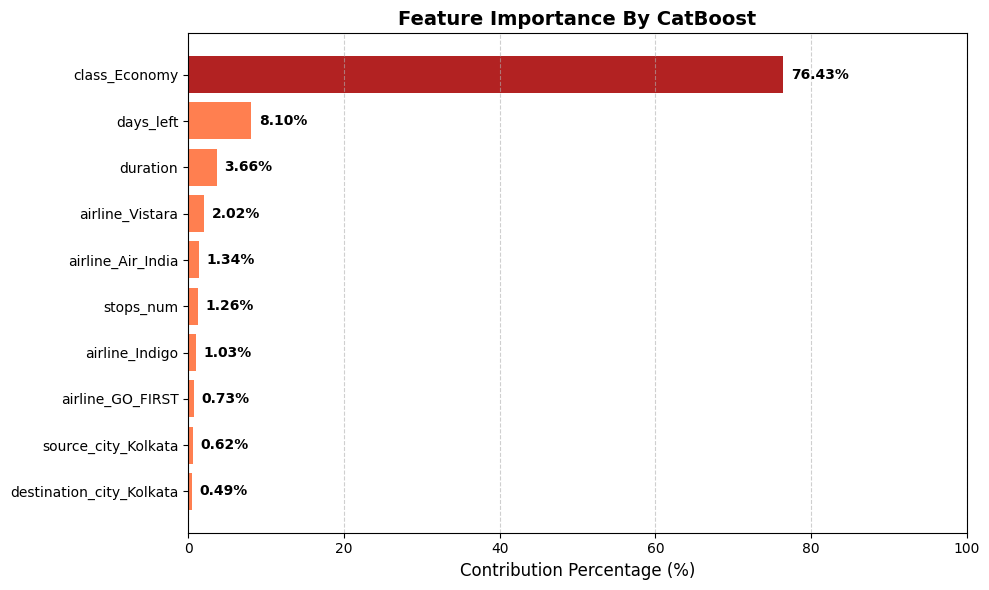

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Create the DataFrame from your data
data = {
    'Predictor': [
        'class_Economy', 'days_left', 'duration', 'airline_Vistara',
        'airline_Air_India', 'stops_num', 'airline_Indigo', 'airline_GO_FIRST',
        'source_city_Kolkata', 'destination_city_Kolkata'
    ],
    'Contribution_Percentage': [
        76.43, 8.10, 3.66, 2.02, 1.34, 1.26, 1.03, 0.73, 0.62, 0.49
    ]
}
df = pd.DataFrame(data).sort_values(by='Contribution_Percentage', ascending=True)

# 2. Plotting
plt.figure(figsize=(10, 6))
# Using a color that stands out for the dominant feature
colors = ['coral' if x < 50 else 'firebrick' for x in df['Contribution_Percentage']]
bars = plt.barh(df['Predictor'], df['Contribution_Percentage'], color=colors)

# 3. Add exact percentage labels to the bars
for bar in bars:
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.2f}%', va='center', fontweight='bold')

plt.title('Feature Importance By CatBoost', fontsize=14, fontweight='bold')
plt.xlabel('Contribution Percentage (%)', fontsize=12)
plt.xlim(0, 100)  # Scale to 100 to show the dominance clearly
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

Generating Partial Dependence Plot for 'days_left'...


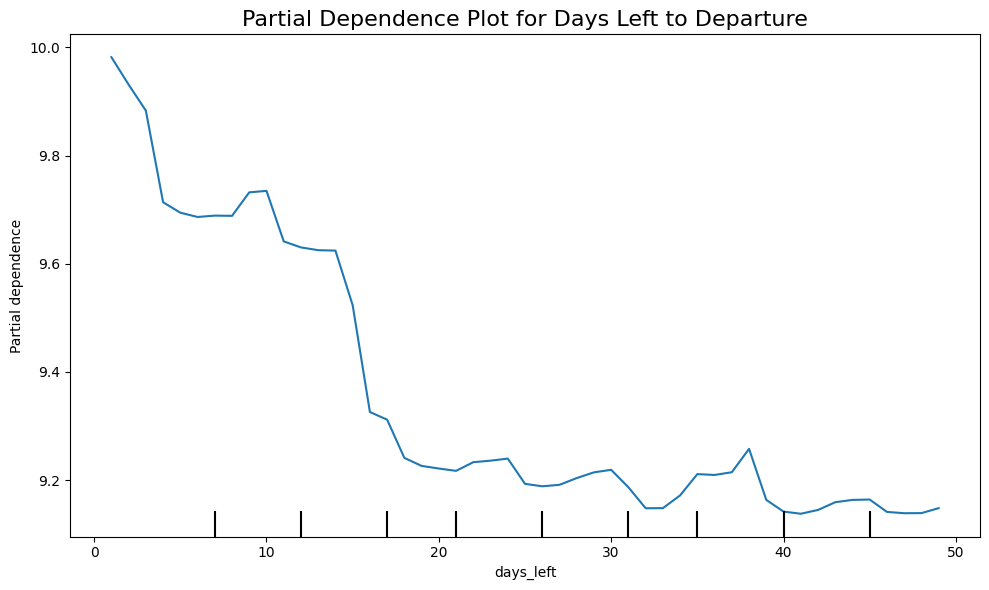

Partial Dependence Plot generated successfully.


In [15]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

print("Generating Partial Dependence Plot for 'days_left'...")

# 1. Create a figure and an axes object
fig, ax = plt.subplots(figsize=(10, 6))

# 2. Generate the Partial Dependence Plot for the 'days_left' feature
# Note: CatBoost models are compatible with scikit-learn's PartialDependenceDisplay
PartialDependenceDisplay.from_estimator(
    estimator=best_cat, # The best-performing CatBoost model
    X=X_train_tree,     # The training data used for tree-based models
    features=['days_left'],
    ax=ax,
    feature_names=X_train_tree.columns.tolist(), # Provide all feature names
    grid_resolution=50 # Number of points to sample for each feature
)

# 3. Set the title of the plot
ax.set_title('Partial Dependence Plot for Days Left to Departure', fontsize=16)

# 4. Label the x-axis and y-axis
ax.set_xlabel('Days Left to Departure', fontsize=12)
ax.set_ylabel('Predicted Log Flight Price', fontsize=12)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()
print("Partial Dependence Plot generated successfully.")

Generating Partial Dependence Plot for 'duration'...


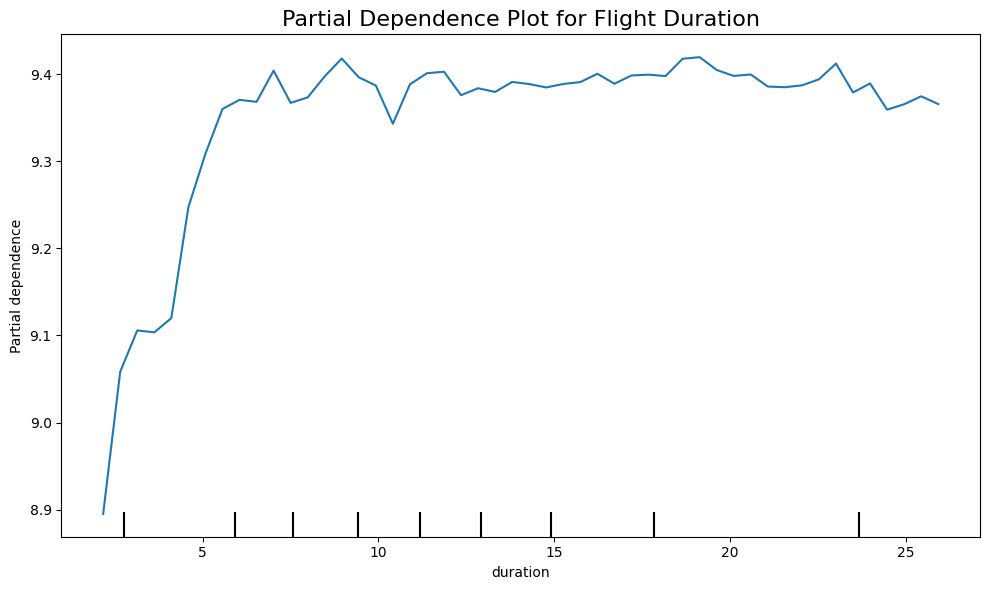

Partial Dependence Plot for 'duration' generated successfully.


In [16]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

print("Generating Partial Dependence Plot for 'duration'...")

# 1. Create a figure and an axes object
fig, ax = plt.subplots(figsize=(10, 6))

# 2. Generate the Partial Dependence Plot for the 'duration' feature
PartialDependenceDisplay.from_estimator(
    estimator=best_cat, # The best-performing CatBoost model
    X=X_train_tree,     # The training data used for tree-based models
    features=['duration'],
    ax=ax,
    feature_names=X_train_tree.columns.tolist(), # Provide all feature names
    grid_resolution=50 # Number of points to sample for each feature
)

# 3. Set the title of the plot
ax.set_title('Partial Dependence Plot for Flight Duration', fontsize=16)

# 4. Label the x-axis and y-axis
ax.set_xlabel('Flight Duration (hours)', fontsize=12)
ax.set_ylabel('Predicted Log Flight Price', fontsize=12)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()
print("Partial Dependence Plot for 'duration' generated successfully.")